In [1]:
# PyTorch Utilities
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm  

##### Dataset stuff

/blue/woodard/mkunzlermaldaner/EXPLOGIC/explogic_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Balanced Train Dataset Size: 54210
Balanced Test Dataset Size: 8920


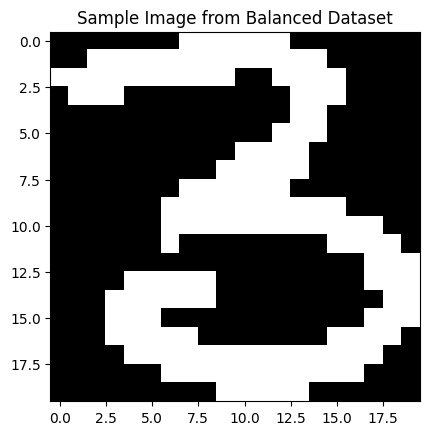

In [2]:
import numpy as np
import random
from utils import dataset_getter as dat
import matplotlib.pyplot as plt

# Dataset and Preprocessing Settings
crop = (20,20)  # Cropping configuration: None removes no border, specify (x,x) for cropping dimensions

# Dataset Selection
# Options: "mnist" or "fashion_mnist"
dataset_name = "mnist"

# Bits Per Pixel (Fixed at 1 for binary data in ExpLogic)
bpp = 1

# Ensuring Reproducibility Across Runs
# Seeds for Random Generators in PyTorch, NumPy, and Python
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# DataLoader Parameters
batch_size = 512
train_loader, test_loader, input_dim, out_dim = dat.get_dataset(
    dataset_name, batch_size=batch_size, data_dir="./data", bpp=bpp, crop=crop
)

# Analyze and Balance Class Distribution in Dataset
train_targets = train_loader.dataset.targets
test_targets = test_loader.dataset.targets

# Class-Wise Sample Count
train_class_counts = [torch.sum(train_targets == i).item() for i in range(10)]
test_class_counts = [torch.sum(test_targets == i).item() for i in range(10)]

# Determine Minimum Samples Per Class for Balanced Dataset
min_samples_train = min(train_class_counts)
min_samples_test = min(test_class_counts)

# Define Function to Trim Datasets for Balance
def balance_dataset(dataset, targets, min_samples):
    indices = []
    for class_label in range(10):
        class_indices = (targets == class_label).nonzero(as_tuple=True)[0]
        indices.extend(class_indices[:min_samples])

    # Shuffle Indices to Randomize the Dataset
    indices = torch.tensor(indices)
    shuffled_indices = indices[torch.randperm(indices.size(0))]
    
    return Subset(dataset, shuffled_indices)

# Apply Balancing to Train and Test Datasets
balanced_train_dataset = balance_dataset(train_loader.dataset, train_targets, min_samples_train)
balanced_test_dataset = balance_dataset(test_loader.dataset, test_targets, min_samples_test)

# Re-Initialize DataLoaders with Balanced Datasets
train_loader_balanced = DataLoader(
    balanced_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True
)
test_loader_balanced = DataLoader(
    balanced_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True
)

# Verify New Dataset Sizes
print(f"Balanced Train Dataset Size: {len(train_loader_balanced.dataset)}")
print(f"Balanced Test Dataset Size: {len(test_loader_balanced.dataset)}")

# Update Loaders and Datasets for Subsequent Use
train_loader = train_loader_balanced
test_loader = test_loader_balanced

# Visualize a Random Image from the Balanced Training Dataset
data_index = random.randint(0, len(train_loader.dataset) - 1)
random_image, _ = train_loader.dataset[data_index]

# Process Image for Display
image_shape = (20, 20) if crop else (28, 28)
processed_image = np.array([
    np.sum([random_image[(i * bpp) + j] * (2 ** (bpp - j + 1)) for j in range(bpp)])
    for i in range(image_shape[0] * image_shape[0])
]).reshape(image_shape)

# Plot the Processed Image
plt.figure()
plt.imshow(processed_image, cmap="gray")
plt.title("Sample Image from Balanced Dataset")
plt.show()

##### CPU Based Logic Layer

In [4]:
class LogicLayer(torch.nn.Module):
    """
    The core module for differentiable logic gate networks. Provides a differentiable logic gate layer.
    """
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            device: str = 'cpu',
            grad_factor: float = 1.,
            implementation: str = 'cpu',
            connections: str = 'random',
    ):
        """
        :param in_dim:      input dimensionality of the layer
        :param out_dim:     output dimensionality of the layer
        :param device:      device (options: 'cpu')
        :param grad_factor: for deep models (>6 layers), the grad_factor should be increased (e.g., 2) to avoid vanishing gradients
        :param implementation: implementation to use (options: 'python').
        :param connections: method for initializing the connectivity of the logic gate net
        """
        super().__init__()
        self.weights = torch.nn.parameter.Parameter(torch.randn(out_dim, 16, device=device))
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device
        self.grad_factor = grad_factor

        # forces implementation to be python and use cpu
        self.implementation = 'python'
        #self.implementation = implementation
  
        if self.implementation is None and device == 'cpu':
            self.implementation = 'python'
        assert self.implementation in ['python'], self.implementation

        self.connections = connections
        assert self.connections in ['random', 'unique'], self.connections
        self.indices = self.get_connections(self.connections, device)

        self.num_neurons = out_dim
        self.num_weights = out_dim

    def forward(self, x):
        if self.implementation == 'python':
            return self.forward_python(x)
        else:
            raise ValueError(self.implementation)

    def forward_python(self, x):
        assert x.shape[-1] == self.in_dim, (x[0].shape[-1], self.in_dim)

        if self.indices[0].dtype == torch.int64 or self.indices[1].dtype == torch.int64:            
            self.indices = self.indices[0].long(), self.indices[1].long()   

        a, b = x[..., self.indices[0]], x[..., self.indices[1]]
        if self.training:
            x = bin_op_s(a, b, torch.nn.functional.softmax(self.weights, dim=-1))
        else:
            weights = torch.nn.functional.one_hot(self.weights.argmax(-1), 16).to(torch.float32)
            x = bin_op_s(a, b, weights)
        return x

    def extra_repr(self):
        return '{}, {}, {}'.format(self.in_dim, self.out_dim, 'train' if self.training else 'eval')

    def get_connections(self, connections, device='cpu'):
        assert self.out_dim * 2 >= self.in_dim, 'The number of neurons ({}) must not be smaller than half of the ' \
                                                'number of inputs ({}) because otherwise not all inputs could be ' \
                                                'used or considered.'.format(self.out_dim, self.in_dim)
        if connections == 'random':
            c = torch.randperm(2 * self.out_dim) % self.in_dim
            c = torch.randperm(self.in_dim)[c]
            c = c.reshape(2, self.out_dim)
            a, b = c[0], c[1]
            a, b = a.to(torch.int64), b.to(torch.int64)
            a, b = a.to(device), b.to(device)
            return a, b
        elif connections == 'unique':
            return get_unique_connections(self.in_dim, self.out_dim, device)
        else:
            raise ValueError(connections)

##### CPU Bin Op S

In [3]:
def bin_op(a, b, i):
    assert a[0].shape == b[0].shape, (a[0].shape, b[0].shape)
    if a.shape[0] > 1:
        assert a[1].shape == b[1].shape, (a[1].shape, b[1].shape)

    if i == 0:
        return torch.zeros_like(a)
    elif i == 1:
        return a * b
    elif i == 2:
        return a - a * b
    elif i == 3:
        return a
    elif i == 4:
        return b - a * b
    elif i == 5:
        return b
    elif i == 6:
        return a + b - 2 * a * b
    elif i == 7:
        return a + b - a * b
    elif i == 8:
        return 1 - (a + b - a * b)
    elif i == 9:
        return 1 - (a + b - 2 * a * b)
    elif i == 10:
        return 1 - b
    elif i == 11:
        return 1 - b + a * b
    elif i == 12:
        return 1 - a
    elif i == 13:
        return 1 - a + a * b
    elif i == 14:
        return 1 - a * b
    elif i == 15:
        return torch.ones_like(a)

def bin_op_s(a, b, i_s):
    device = 'cpu'
    b = b.to(device)
    i_s = i_s.to(device)

    r = torch.zeros_like(a, device=device)
    for i in range(16):
        u = bin_op(a, b, i)
        r = r + i_s[..., i] * u
    return r

##### CPU Based GroupSum function

In [5]:
class GroupSum(torch.nn.Module):
    """
    The GroupSum module.
    """
    def __init__(self, k: int, tau: float = 1., device='cpu'):
        """
        :param k: number of intended real valued outputs, e.g., number of classes
        :param tau: the (softmax) temperature tau. The summed outputs are divided by tau.
        :param device: cpu
        """
        super().__init__()
        self.k = k
        self.tau = tau
        self.device = device

    def forward(self, x):
        assert x.shape[-1] % self.k == 0, (x.shape, self.k)
        return x.reshape(*x.shape[:-1], self.k, x.shape[-1] // self.k).sum(-1) / self.tau

    def extra_repr(self):
        return 'k={}, tau={}'.format(self.k, self.tau)

##### CPU Based DiffLogic

In [6]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """        
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model', model_cfg=None):
        """
        Saves the model's state dictionary plus all relevant architecture info
        to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model.
            model_cfg (dict): The full dictionary that contains layer config,
                              output_size, tau, learning rate, etc.
        """
        checkpoint_data = {
            'model_state_dict': self.state_dict(),
            'connections': [
                layer.indices 
                for layer in self.logic_layers 
                if isinstance(layer, LogicLayer)
            ],
            # Store the entire config so you can reconstruct everything
            'model_config': {
                'layers_config': model_cfg['layers_config'],
                'output_size': model_cfg['output_size'],
                'tau': model_cfg['tau'],
                'learning_rate': model_cfg.get('learning_rate', None),
            }
        }

        # Now dump that all out to disk
        torch.save(checkpoint_data, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"


    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
     
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cpu'), batch_outputs.to('cpu')

                # forward pass to get predictions
                outputs = self(batch_inputs.float())

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

##### Model Loading without Cuda

In [8]:
dataset_name = 'mnist_mini'
model_name = 'model_001'
file_path = f'trained_models/{dataset_name}_trained_models/{model_name}.pth' # where to save your trained models
checkpoint = torch.load(file_path, map_location="cpu") 

In [9]:
# Access the layers_config part of the model_config
layers_config = checkpoint['model_config']['layers_config']

# Iterate through each layer and update 'device' and 'implementation' keys if they are 'cuda'
for layer_name, config in layers_config.items():
    if config.get('device') == 'cuda':
        config['device'] = 'cpu'
    if config.get('implementation') == 'cuda':
        config['implementation'] = 'cpu'

# Verify the changes
loaded_config = checkpoint['model_config']
print(loaded_config)

{'layers_config': {'LogicLayer001': {'connections': 'random', 'device': 'cpu', 'grad_factor': 2, 'implementation': 'cpu', 'in_dim': 81, 'out_dim': 50}, 'LogicLayer002': {'connections': 'random', 'device': 'cpu', 'grad_factor': 2, 'implementation': 'cpu', 'in_dim': 50, 'out_dim': 50}}, 'output_size': 10, 'tau': 10, 'learning_rate': 0.01}


In [10]:
# Now reconstruct the model using the saved config
model_reconstructed = DiffLogic(
    layers_config=loaded_config['layers_config'],
    output_size=loaded_config['output_size'],
    tau=loaded_config['tau']
)

# Load the state_dict
model_reconstructed.load_state_dict(checkpoint['model_state_dict'])

# If needed, also restore the connections
for idx, layer in enumerate(model_reconstructed.logic_layers):
    if isinstance(layer, LogicLayer):
        layer.indices = checkpoint['connections'][idx]

model_reconstructed.eval()

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)


DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, eval)
    (1): LogicLayer(50, 50, eval)
  )
  (group): GroupSum(k=10, tau=10)
)

In [12]:
#model_reconstructed.get_accuracy(test_loader)

#### Gets connections

In [13]:
def get_all_connections(model):
    
    # map gate names to indices
    ALL_OPERATIONS = [
        "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
        "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
    ]

    gates_per_layer = []
    
    for layer_idx, layer in enumerate(model.logic_layers):
        layer_connections = []
        
        # for each neuron in the layer
        for neuron_idx in range(layer.weights.size(0)):
            # get the learned gate by taking the argmax of the weights for the neuron
            gate_op_idx = layer.weights[neuron_idx].argmax().item()
            learned_gate = ALL_OPERATIONS[gate_op_idx]

            # get the input connections (indices) for the gate
            input_neuron_a = layer.indices[0][neuron_idx].item()
            input_neuron_b = layer.indices[1][neuron_idx].item()

            # store the gate and connections
            layer_connections.append({
                'neuron_idx': neuron_idx,
                'gate': learned_gate,
                'inputs': (input_neuron_a, input_neuron_b),
            })
        
        gates_per_layer.append(layer_connections)
    
    return gates_per_layer

# retrieve all connections for the model
connections = get_all_connections(model_reconstructed)
connections[0][:5] # example displaying the first 5

[{'neuron_idx': 0, 'gate': 'not_xor', 'inputs': (18, 50)},
 {'neuron_idx': 1, 'gate': 'or', 'inputs': (54, 43)},
 {'neuron_idx': 2, 'gate': 'not_xor', 'inputs': (60, 74)},
 {'neuron_idx': 3, 'gate': 'a', 'inputs': (68, 15)},
 {'neuron_idx': 4, 'gate': 'or', 'inputs': (68, 63)}]

#### **The Forward Pass**

Once the user enters an image, we need to return 2 things to the Frontend:
1. The actual class prediction of that input
2. A dictionary containing a list of which nodes fired (were activated) so we can display them

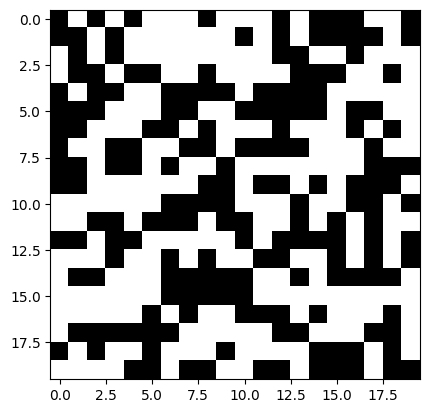

In [43]:
# Sample image for demonstration purposes
sample_image = (torch.randn(1, layers_config['LogicLayer001']['in_dim']) > 0).float()
plt.imshow((sample_image.reshape((20, 20))), cmap='gray')

1. The actual class prediction for a certain input (e.g. the image above)

All class probabilities

In [41]:
model_reconstructed(sample_image)

tensor([[14.4000, 11.8000, 13.6000, 12.0000, 12.0000, 12.4000, 12.9000, 10.3000,
         13.1000, 11.0000]])

Finding highest class probability

In [42]:
model_reconstructed(sample_image).argmax()

tensor(0)

2. The path our image took

In [44]:
# [in progress]